Text(0.5, 1.0, 'Dataset 1')

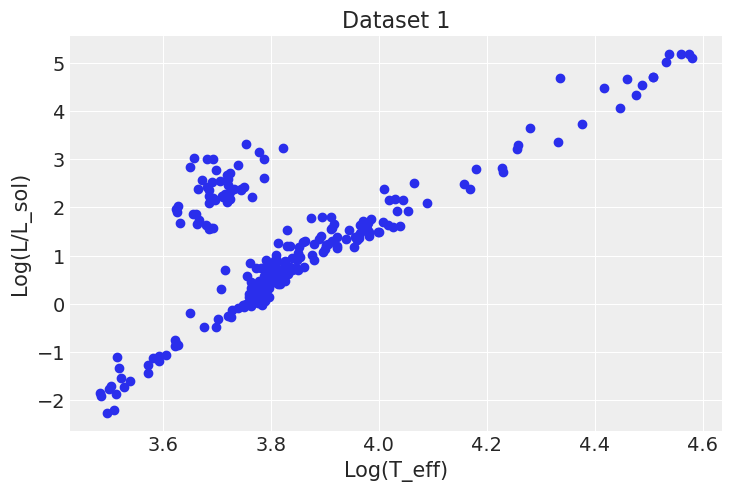

In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import scipy

df = Table.read('https://www.astro.keele.ac.uk/jkt/debcat/debs.dat', format='ascii').to_pandas()

#filter out erroneous values
df = df[df['logL1'] > -3]

logT1 = df["logT1"]
logT1 = np.array(logT1)
logL1 = df["logL1"]
logL1 = np.array(logL1)

plt.scatter(logT1, logL1)
plt.xlabel('Log(T_eff)')
plt.ylabel('Log(L/L_sol)')
plt.title('Dataset 1')

(array([ 2.,  4.,  4.,  2.,  6.,  3.,  1.,  4.,  8., 16., 29., 29., 23.,
        12., 17., 22., 11., 13., 16.,  8.,  7.,  5.,  5.,  1.,  1.,  1.,
         1.,  3.,  3.,  5.]),
 array([-2.258     , -2.00983333, -1.76166667, -1.5135    , -1.26533333,
        -1.01716667, -0.769     , -0.52083333, -0.27266667, -0.0245    ,
         0.22366667,  0.47183333,  0.72      ,  0.96816667,  1.21633333,
         1.4645    ,  1.71266667,  1.96083333,  2.209     ,  2.45716667,
         2.70533333,  2.9535    ,  3.20166667,  3.44983333,  3.698     ,
         3.94616667,  4.19433333,  4.4425    ,  4.69066667,  4.93883333,
         5.187     ]),
 <BarContainer object of 30 artists>)

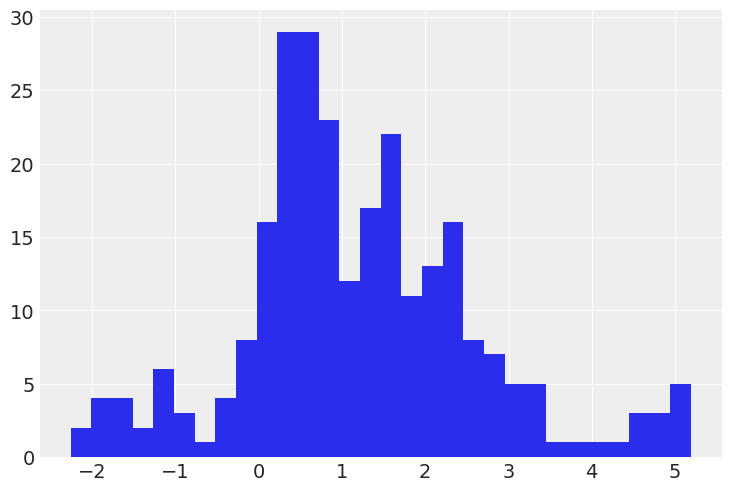

In [259]:
plt.hist(logL1, bins=30)

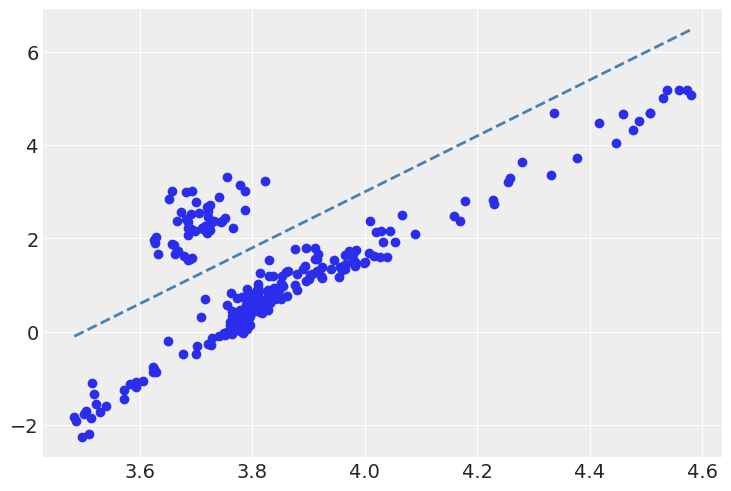

In [260]:
x = np.arange(3.5, 4.6, 0.01)
y = 6*x - 21
plt.scatter(logT1, logL1)
#plt.plot(x, y, color='steelblue', linestyle='--', linewidth=2)
plt.plot(logT1, 6*logT1 -21, color='steelblue', linestyle='--', linewidth=2)

In [261]:
logT1_cut = logT1[logL1 < (6*logT1-21)]
logL1_cut = logL1[logL1 < (6*logT1-21)]

#filter the errors as well
logT1_err = df['logT1e'][logL1 < (6*logT1-21)]
logL1_err = df['logL1e'][logL1 < (6*logT1-21)]

logT1_err = np.array(logT1_err)
logL1_err = np.array(logL1_err)

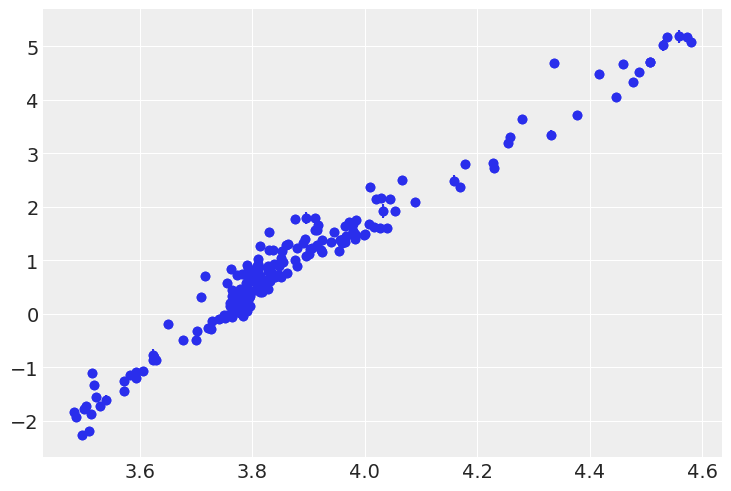

In [262]:
plt.scatter(logT1_cut, logL1_cut)
plt.errorbar(logT1_cut, logL1_cut, yerr=logL1_err, fmt="o")
plt.show()

#error bars on values are so small they hardly show up on the scatter plot
#and they're already transformed in log space so that's not an issue either

In [263]:
import sklearn
from scipy.stats import poisson
from sklearn.linear_model import LinearRegression
import arviz as az
import pymc

In [264]:
from pymc import Model, Normal, Gamma

# Without Known Errors

In [265]:
y = logL1_cut
x1 = logT1_cut

In [266]:
# one that does not include errors
basic_model = Model()

with basic_model:
    # Priors for unknown model parameters
    beta = Normal('beta', mu=0, tau=1./1000, shape=2)
    precision = Gamma('precision', alpha=0.5, beta=0.5)
    # Expected value of outcome
    mu = beta[0] + beta[1]*x1 
    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, tau=precision, observed=y)

In [267]:
from pymc import find_MAP
#import pprint
#pp = pprint.PrettyPrinter(indent=4)
map_estimate = find_MAP(model = basic_model)
map_estimate

{'beta': array([-23.60795949,   6.33604984]),
 'precision_log__': array(2.4255216),
 'precision': array(11.30812616)}

In [268]:
with basic_model:
    start = find_MAP() 
    # draw "draws" posterior samples
    trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=1000)

/var/folders/36/5ssmgg1n0kgbmjfhm188d5br0000gn/T/ipykernel_71634/2962861299.py:4: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, precision]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


In [269]:
# Get the posterior dataset
posterior = trace.posterior
posterior

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 1000, beta_dim_0: 2)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * beta_dim_0  (beta_dim_0) int64 0 1
Data variables:
    beta        (chain, draw, beta_dim_0) float64 -23.73 6.371 ... -23.69 6.357
    precision   (chain, draw) float64 10.9 10.51 11.08 ... 13.14 12.27 12.3
Attributes:
    created_at:                 2022-11-16T02:58:50.855176
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0
    sampling_time:              30.625003576278687
    tuning_steps:               1000

array([[<AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'beta'}>],
       [<AxesSubplot: title={'center': 'precision'}>,
        <AxesSubplot: title={'center': 'precision'}>]], dtype=object)

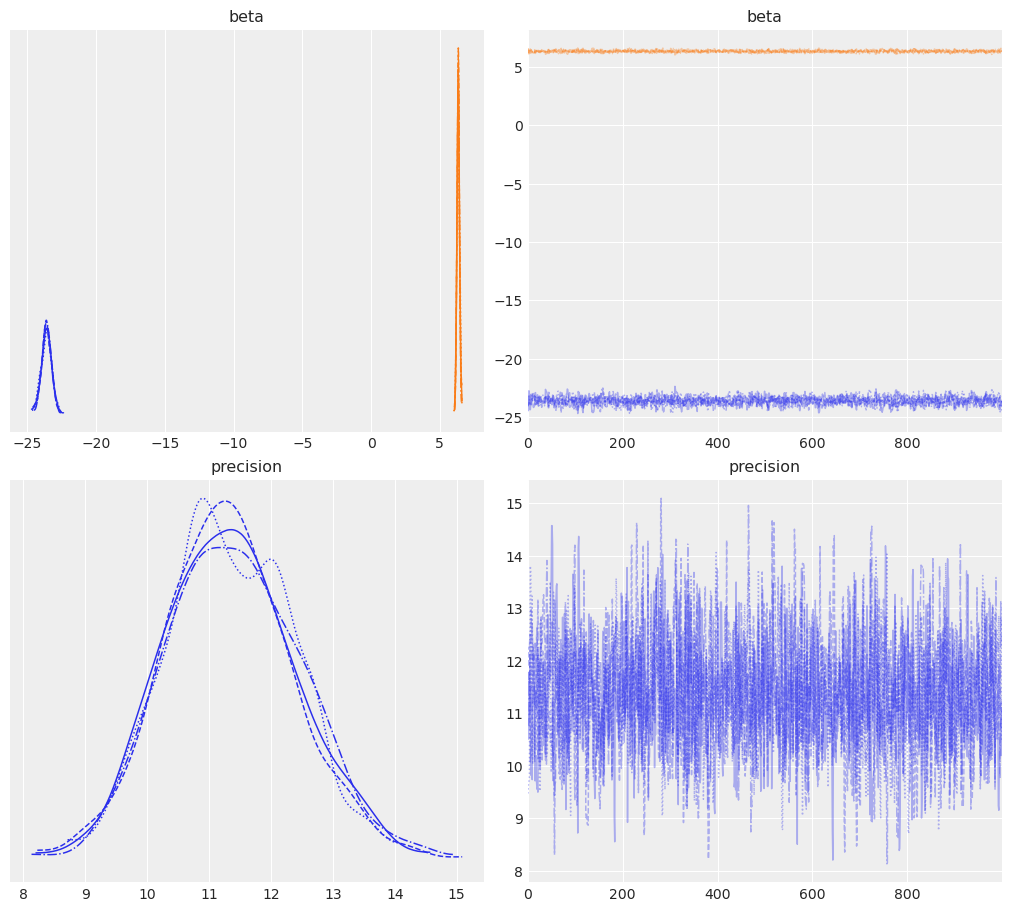

In [270]:
az.plot_trace(trace,figsize=(10, 9))

In [271]:
az.summary(trace, hdi_prob=0.95) # HDI Highest Density Interval 5%

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-23.615,0.358,-24.333,-22.911,0.009,0.006,1610.0,1757.0,1.0
beta[1],6.338,0.092,6.151,6.516,0.002,0.002,1606.0,1757.0,1.0
precision,11.354,1.071,9.342,13.535,0.024,0.017,1920.0,1900.0,1.0


array([<AxesSubplot: title={'center': 'beta\n0'}>,
       <AxesSubplot: title={'center': 'beta\n1'}>,
       <AxesSubplot: title={'center': 'precision'}>], dtype=object)

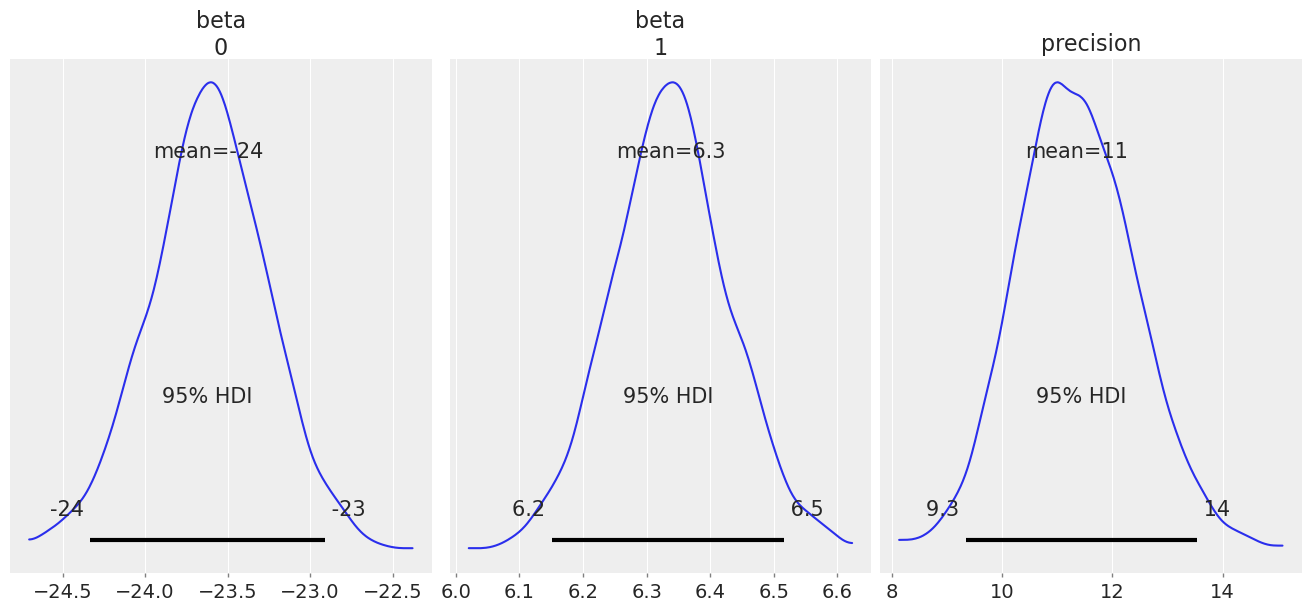

In [272]:
az.plot_posterior(trace, figsize=(13, 6), hdi_prob=0.95)

array([<AxesSubplot: title={'center': 'beta\n0'}>,
       <AxesSubplot: title={'center': 'beta\n1'}>], dtype=object)

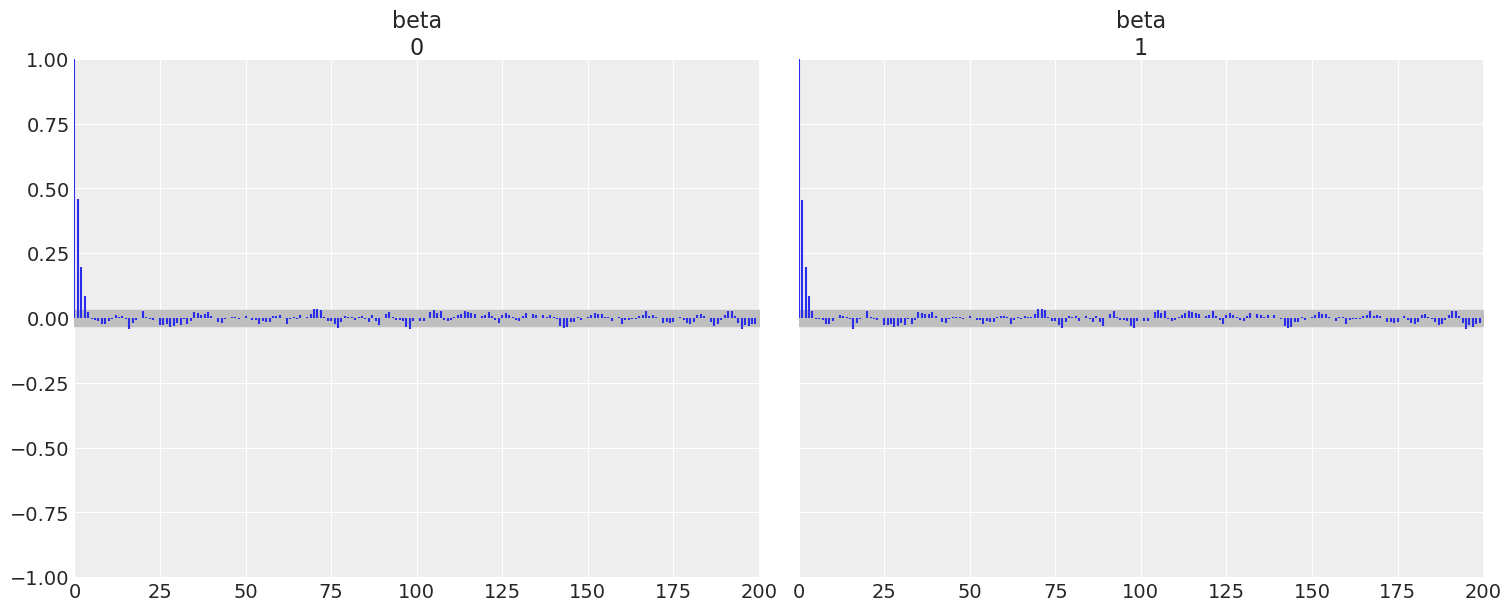

In [273]:
az.plot_autocorr(trace, var_names=['beta'], filter_vars="like",  max_lag=200, combined=True, figsize=(15, 6))

In [274]:
with basic_model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

trace.posterior_predictive

Sampling: [Y_obs]


<xarray.Dataset>
Dimensions:      (chain: 4, draw: 1000, Y_obs_dim_2: 212)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * Y_obs_dim_2  (Y_obs_dim_2) int64 0 1 2 3 4 5 6 ... 206 207 208 209 210 211
Data variables:
    Y_obs        (chain, draw, Y_obs_dim_2) float64 -1.552 -1.409 ... 4.94 5.123
Attributes:
    created_at:                 2022-11-16T02:59:08.603045
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0

<AxesSubplot: xlabel='Y_obs / Y_obs'>

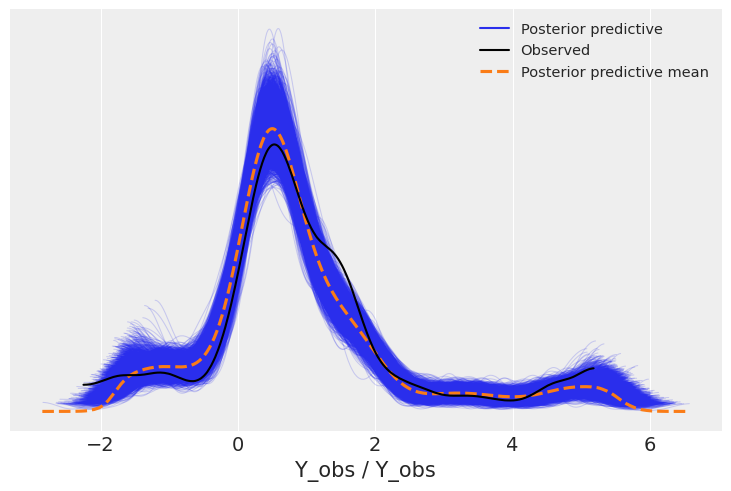

In [275]:
az.plot_ppc(trace)

In [276]:
az.summary(trace.posterior_predictive, hdi_prob = 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Y_obs[0],-1.542,0.303,-2.150,-0.971,0.005,0.004,3682.0,3765.0,1.0
Y_obs[1],-1.454,0.295,-2.035,-0.895,0.005,0.003,3881.0,3470.0,1.0
Y_obs[2],-1.366,0.299,-1.956,-0.798,0.005,0.004,3223.0,3558.0,1.0
Y_obs[3],-1.346,0.302,-1.942,-0.780,0.005,0.003,4069.0,3794.0,1.0
Y_obs[4],-1.517,0.304,-2.100,-0.903,0.005,0.003,3905.0,3970.0,1.0
...,...,...,...,...,...,...,...,...,...
Y_obs[207],5.371,0.308,4.792,5.997,0.005,0.003,3882.0,3759.0,1.0
Y_obs[208],5.097,0.303,4.457,5.651,0.005,0.003,3975.0,3776.0,1.0
Y_obs[209],5.146,0.301,4.558,5.717,0.005,0.003,3945.0,3851.0,1.0
Y_obs[210],5.283,0.312,4.658,5.875,0.005,0.004,3600.0,3414.0,1.0


# With Known Errors

In [277]:
a = logL1_err ** (-2)
b = logT1_err ** (-2)
y_obs = y
x_obs = x1
c = d = 1e-3
e = f = 0.5

In [279]:
basic_model = Model()

with basic_model:
    # Priors for unknown model parameters
    tau = Gamma('tau', alpha=e, beta=f)
    X1 = Normal("X1", mu=0, tau=tau, shape=212)
    beta = Normal('beta', mu=0, tau=d, shape=2)
    Y = Normal("Y", mu=beta[0] + beta[1]*X1, tau=tau)
    # Likelihood (sampling distribution) of observations
    Y_star = Normal('Y_star', mu=Y, tau=a, observed=y_obs)
    X1_star = Normal('X_star', mu=X1, tau=b, observed=x_obs)

In [280]:
from pymc import find_MAP
import pprint
pp = pprint.PrettyPrinter(indent=4)
map_estimate = find_MAP(model = basic_model)
pp.pprint(map_estimate)


{   'X1': array([3.482912  , 3.49588539, 3.50997087, 3.51494968, 3.48553913,
       3.51287022, 3.52797828, 3.499665  , 3.5038313 , 3.53858978,
       3.51799574, 3.5719686 , 3.52188115, 3.59290638, 3.57189699,
       3.6049733 , 3.58191907, 3.59286306, 3.6279306 , 3.62372761,
       3.79598108, 3.62293293, 3.6987737 , 3.7839307 , 3.78996124,
       3.62276835, 3.78495937, 3.77198108, 3.79298467, 3.78694281,
       3.67687393, 3.78895482, 3.72581889, 3.77999454, 3.77499533,
       3.7489223 , 3.72797774, 3.70189237, 3.75996418, 3.72084197,
       3.76394415, 3.73995881, 3.75095581, 3.75395817, 3.77696317,
       3.64996432, 3.7869956 , 3.75993764, 3.76292561, 3.77194988,
       3.77097486, 3.77296726, 3.76399316, 3.77495341, 3.76697812,
       3.77298667, 3.78198334, 3.77097788, 3.78796967, 3.77794036,
       3.77096746, 3.77498864, 3.80099701, 3.78098705, 3.80399123,
       3.78296986, 3.77799039, 3.79293159, 3.79199873, 3.76388896,
       3.7839952 , 3.79596198, 3.79197398, 3.814861

In [281]:
trace.posterior.dims

Frozen({'chain': 4, 'draw': 1000, 'beta_dim_0': 2})

In [282]:
# Initialize random number generator
RANDOM_SEED = 5731
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")

print(f"Running on PyMC v{pm.__version__}")

with basic_model:
    start = find_MAP() 
    #step = pm.Metropolis()
    # draw 1000 posterior samples
    trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=1000) # step=step

# These general samplers take too long.
# The dimension is too high due to X and Y random vectors.
# Suggest using the Gibbs samplers in R with code provided in LinearRegressionME.pdf page 11. 

Running on PyMC v4.3.0


/var/folders/36/5ssmgg1n0kgbmjfhm188d5br0000gn/T/ipykernel_71634/195832788.py:13: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=1000) # step=step
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, X1, beta, Y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.


In [283]:
# Get the posterior dataset
posterior = trace.posterior
posterior

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 1000, X1_dim_0: 212, beta_dim_0: 2,
                 Y_dim_0: 212)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * X1_dim_0    (X1_dim_0) int64 0 1 2 3 4 5 6 7 ... 205 206 207 208 209 210 211
  * beta_dim_0  (beta_dim_0) int64 0 1
  * Y_dim_0     (Y_dim_0) int64 0 1 2 3 4 5 6 7 ... 205 206 207 208 209 210 211
Data variables:
    X1          (chain, draw, X1_dim_0) float64 3.481 3.494 ... 4.564 4.572
    beta        (chain, draw, beta_dim_0) float64 -21.11 5.698 ... -22.58 5.962
    Y           (chain, draw, Y_dim_0) float64 -1.869 -2.243 ... 5.225 5.092
    tau         (chain, draw) float64 0.1281 0.1484 0.1274 ... 0.1293 0.1347
Attributes:
    created_at:                 2022-11-16T03:03:30.530483
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0
    sampling_time:              47.74707579612732
    tuning_steps:               1000

array([[<AxesSubplot: title={'center': 'tau'}>,
        <AxesSubplot: title={'center': 'tau'}>]], dtype=object)

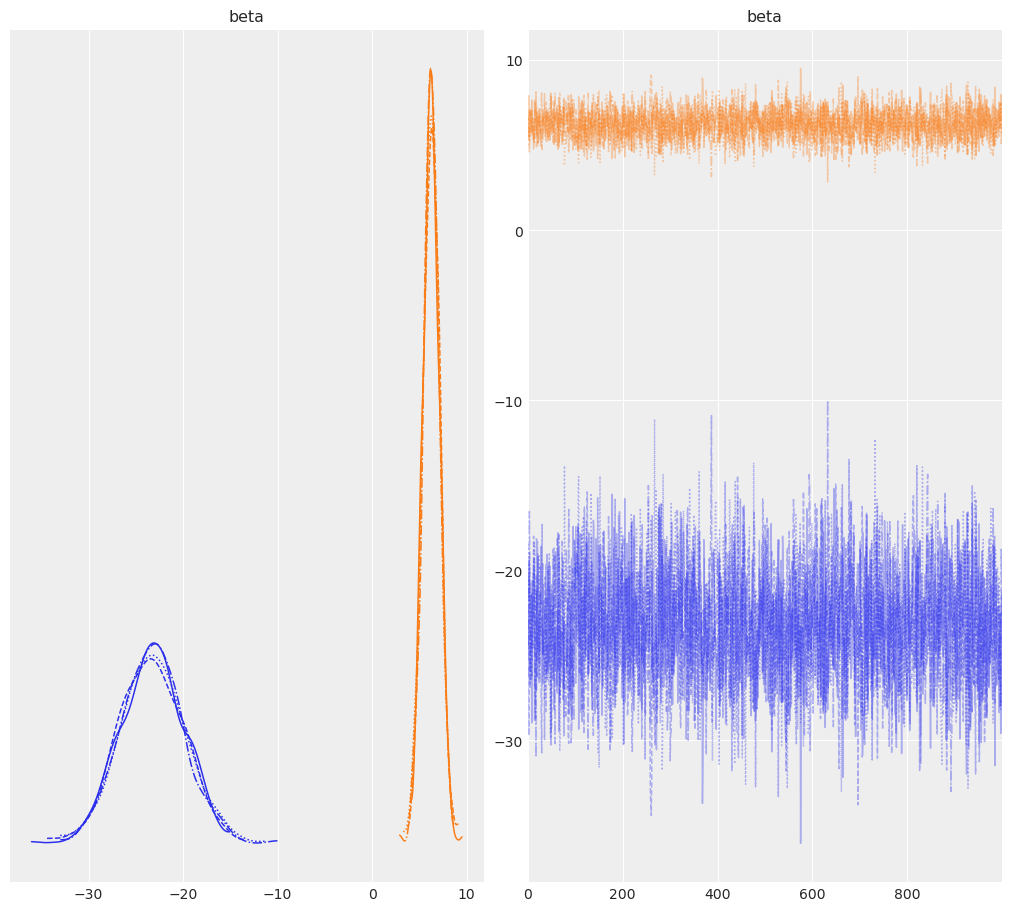

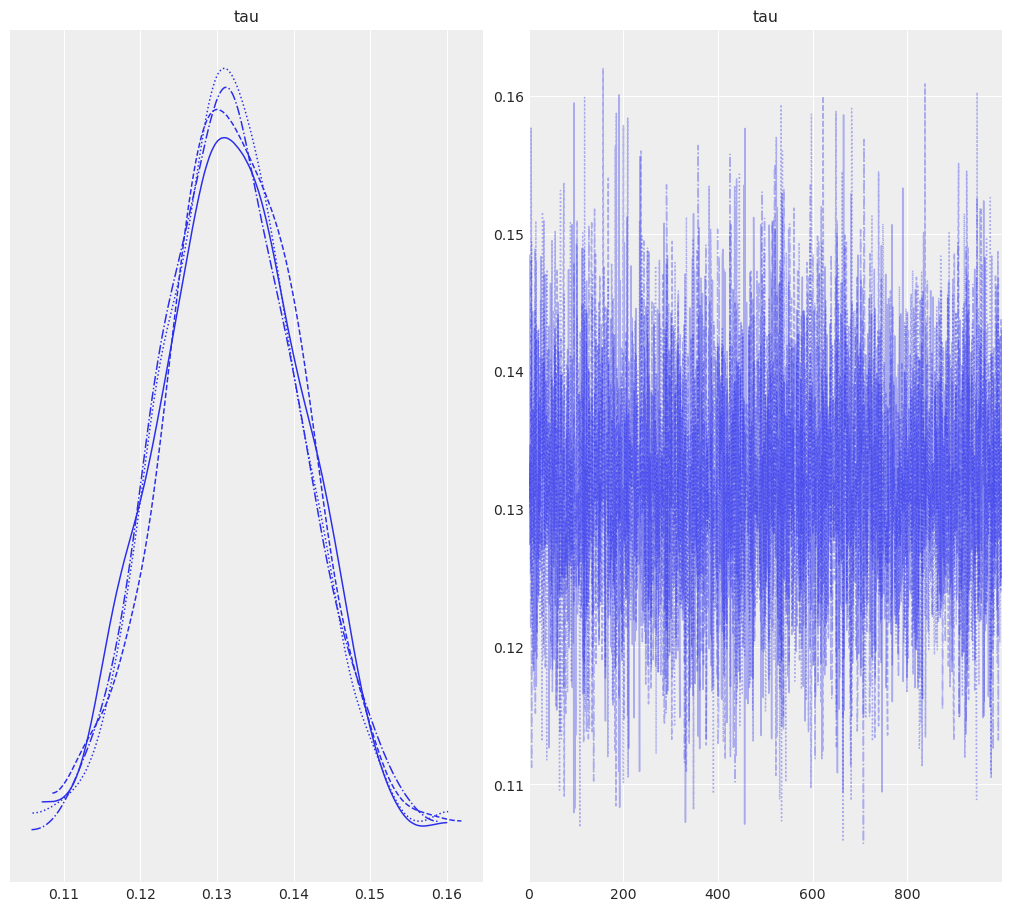

In [284]:
az.plot_trace(trace.posterior["beta"],figsize=(10, 9))
az.plot_trace(trace.posterior["tau"],figsize=(10, 9))

In [285]:
az.summary(trace.posterior[["beta","tau"]], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-23.253,3.337,-29.624,-16.519,0.066,0.047,2568.0,2924.0,1.0
beta[1],6.244,0.859,4.472,7.855,0.017,0.012,2588.0,2820.0,1.0
tau,0.132,0.009,0.115,0.150,0.000,0.000,6740.0,3112.0,1.0


array([<AxesSubplot: title={'center': 'beta\n0'}>,
       <AxesSubplot: title={'center': 'beta\n1'}>,
       <AxesSubplot: title={'center': 'tau'}>], dtype=object)

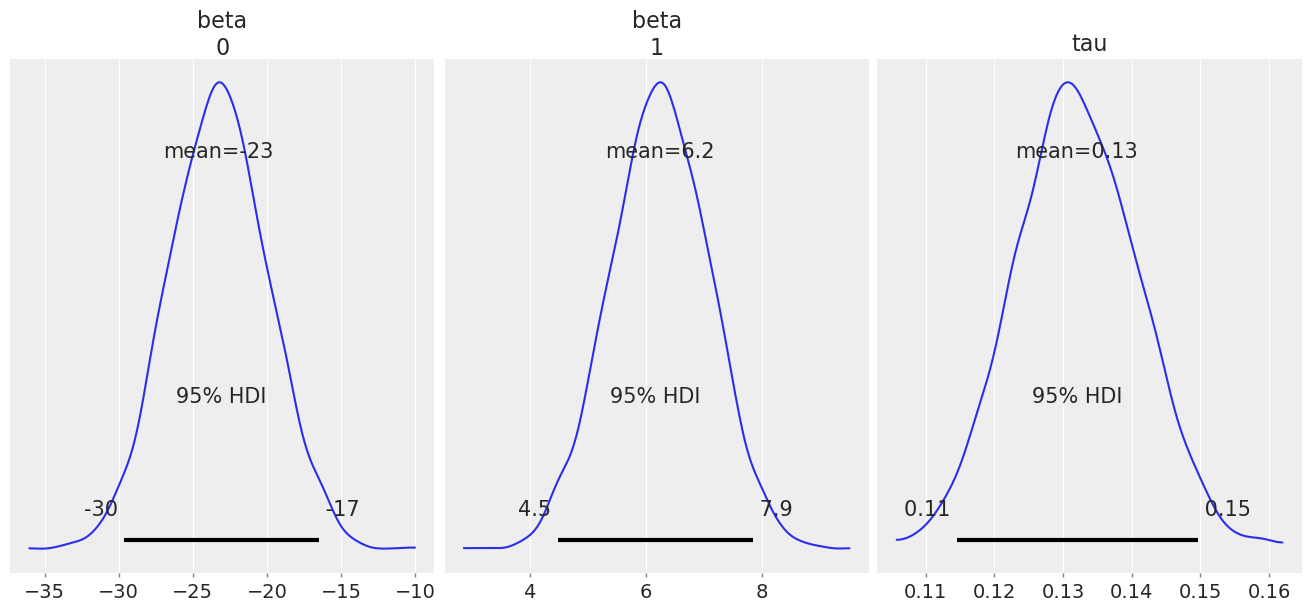

In [286]:
az.plot_posterior(trace.posterior[["beta","tau"]],figsize=(13, 6), hdi_prob=0.95)

In [287]:
print(az.ess(trace,var_names=['beta']))

<xarray.Dataset>
Dimensions:     (beta_dim_0: 2)
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 0 1
Data variables:
    beta        (beta_dim_0) float64 2.568e+03 2.588e+03


array([<AxesSubplot: title={'center': 'beta\n0'}>,
       <AxesSubplot: title={'center': 'beta\n1'}>], dtype=object)

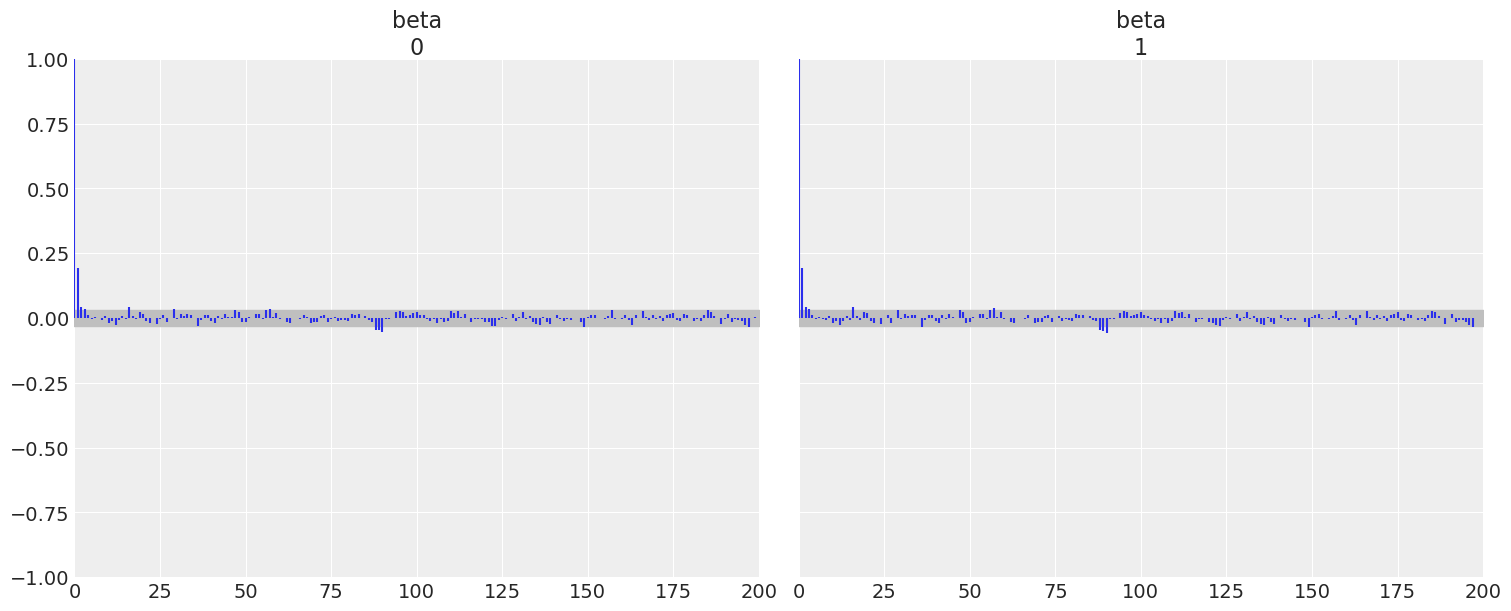

In [288]:
az.plot_autocorr(trace, var_names=['beta'], filter_vars="like",  max_lag=200,combined=True,figsize=(15, 6))


In [289]:
# Posterior Predictive Sampling
with basic_model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

trace.posterior_predictive

Sampling: [X_star, Y_star]


<xarray.Dataset>
Dimensions:       (chain: 4, draw: 1000, Y_star_dim_2: 212, X_star_dim_2: 212)
Coordinates:
  * chain         (chain) int64 0 1 2 3
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * Y_star_dim_2  (Y_star_dim_2) int64 0 1 2 3 4 5 6 ... 206 207 208 209 210 211
  * X_star_dim_2  (X_star_dim_2) int64 0 1 2 3 4 5 6 ... 206 207 208 209 210 211
Data variables:
    Y_star        (chain, draw, Y_star_dim_2) float64 -1.852 -2.252 ... 5.1
    X_star        (chain, draw, X_star_dim_2) float64 3.463 3.5 ... 4.526 4.544
Attributes:
    created_at:                 2022-11-16T03:04:50.722690
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0

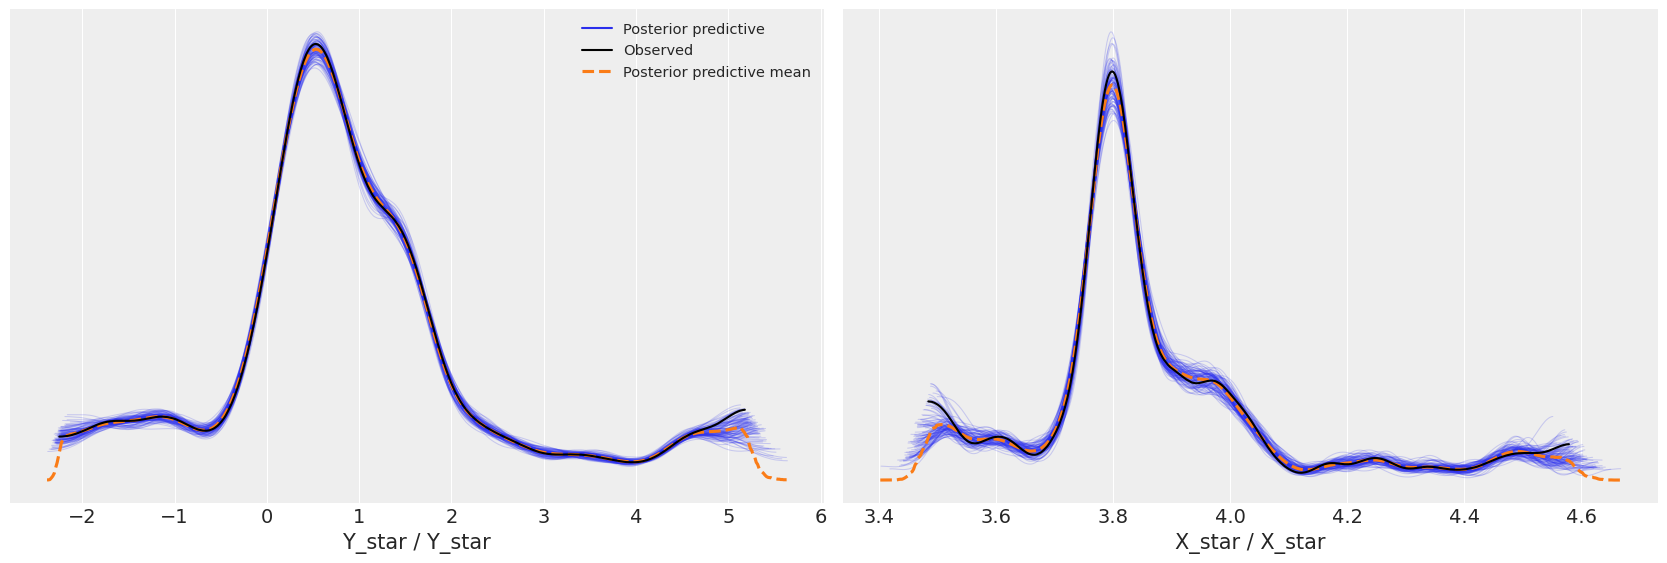

In [290]:
az.plot_ppc(trace, num_pp_samples=100);

# Extremely Basic Linear Regression Model

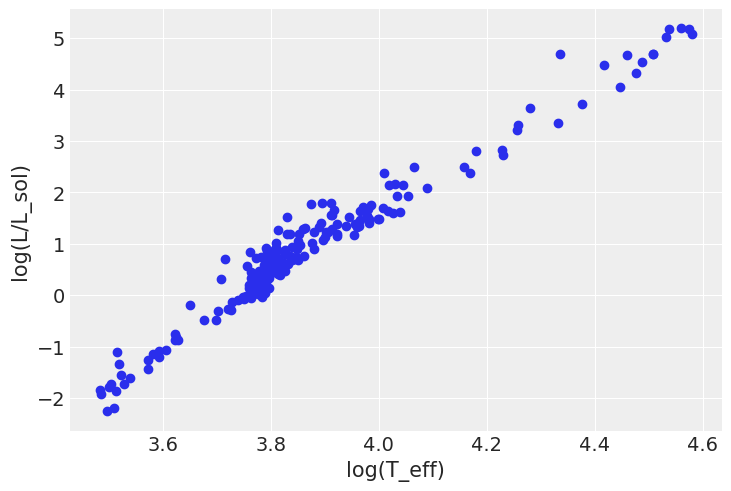

In [294]:
plt.scatter(logT1_cut, logL1_cut)
plt.xlabel("log(T_eff)")
plt.ylabel("log(L/L_sol)")
plt.show()

In [295]:
from sklearn.linear_model import LinearRegression

In [296]:
x = logT1_cut.reshape((-1, 1))
y = logL1_cut

In [297]:
model = LinearRegression()

In [298]:
model = LinearRegression().fit(x, y)

In [300]:
r_sq = model.score(x, y)
print(f"r**2: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

r**2: 0.9589282266653181
intercept: -23.61122802754432
slope: [6.3368916]


In [302]:
print(np.min(logT1_cut))
print(np.max(logT1_cut))

3.483
4.58


In [331]:
x_sp = np.linspace(3.4, 4.66, 1000)
y = (6.337 * x_sp) + -23.611
y_2 = (6.338 * x_sp) + -23.615
y_3 = (6.244 * x_sp) + -23.253

# Comparing All Models:

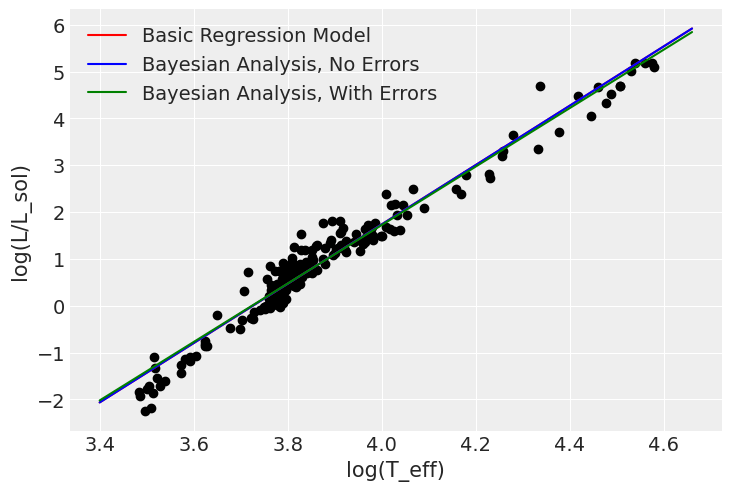

In [332]:
plt.scatter(logT1_cut, logL1_cut, color='black')
plt.plot(x_sp, y, color='red', label='Basic Regression Model')
plt.plot(x_sp, y_2, color='blue', label='Bayesian Analysis, No Errors')
plt.plot(x_sp, y_3, color='green', label='Bayesian Analysis, With Errors')
plt.xlabel("log(T_eff)")
plt.ylabel("log(L/L_sol)")
plt.legend(loc='upper left')
plt.show()

Basic model (scikitt linear regression) and Bayesian analysis model w/out errors are almost identical and therefore cannot be differentiated from one another on the map, Bayesian analysis model w/ errors is slightly different but very close to the other two. 